In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# For displaying images in the notebook
%matplotlib inline


In [2]:
# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Define dataset directory
dataset_directory = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  # Update with the correct path if necessary

# Define classes
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']


In [3]:
import shutil
from sklearn.model_selection import train_test_split

# Create directories for train, validation, and test sets
base_dir = 'kidney_split_dataset'  # Base directory for split dataset

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(os.path.join(base_dir, 'train'))
    os.makedirs(os.path.join(base_dir, 'validation'))
    os.makedirs(os.path.join(base_dir, 'test'))

    for subset in ['train', 'validation', 'test']:
        for class_name in classes:
            os.makedirs(os.path.join(base_dir, subset, class_name))

    # Split data and copy images
    for class_name in classes:
        class_dir = os.path.join(dataset_directory, class_name)
        images = os.listdir(class_dir)
        train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=0.1111, random_state=42)  # Approx. 10% for validation

        # Copy training images
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'train', class_name, img)
            shutil.copyfile(src, dst)

        # Copy validation images
        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'validation', class_name, img)
            shutil.copyfile(src, dst)

        # Copy test images
        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'test', class_name, img)
            shutil.copyfile(src, dst)


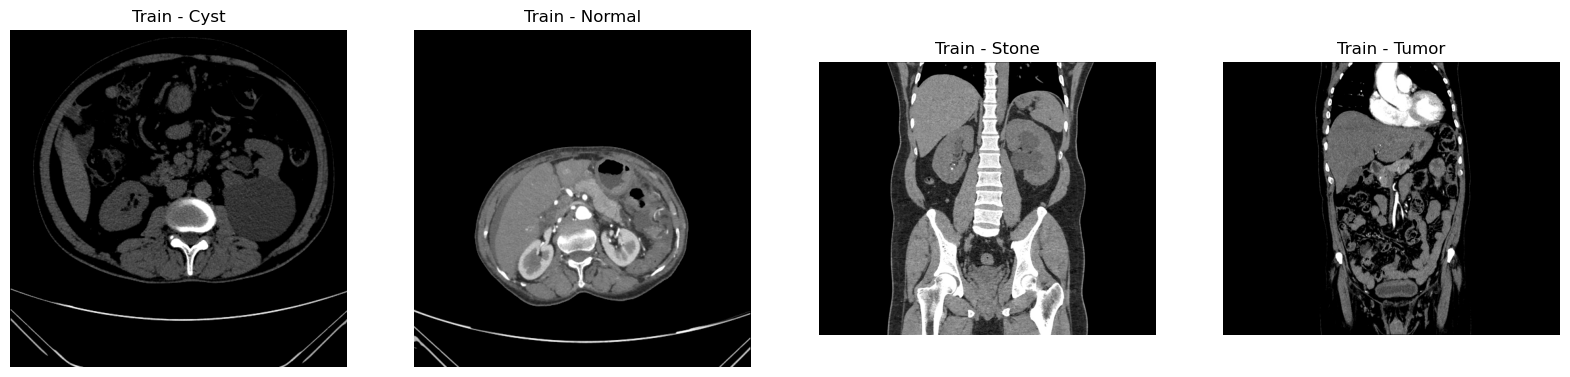

In [14]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def visualize_samples(directory, subset='train'):
    fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(20, 5))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, subset, class_name)
        img_list = os.listdir(class_dir)
        img_name = random.choice(img_list)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{subset.capitalize()} - {class_name}')
        axes[i].axis('off')

    plt.show()

visualize_samples(base_dir, 'train')


In [11]:
def preprocess_image(image):
    # Resize and normalize image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image

def preprocess_sequence(image_paths):
    # Load and preprocess a sequence of images
    images = [preprocess_image(tf.image.decode_jpeg(tf.io.read_file(img))) for img in image_paths]
    return tf.stack(images, axis=0)  # Stack into a single tensor for 3D CNN or CNN-LSTM


In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])


In [15]:
# Step 6: Initialize Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

# Define class weights after initializing train_generator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# Validation and Test data generators
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)


Found 9954 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [38]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, GlobalAveragePooling3D
from tensorflow.keras import Input, Model

# Define input shape for a 3D CNN: (sequence_length, height, width, channels)
sequence_length = 3  # Number of frames in each sequence
inputs = Input(shape=(sequence_length, IMG_HEIGHT, IMG_WIDTH, 1))

# 3D Convolutional layers to capture spatio-temporal features
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)  # Only downsample spatial dimensions
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)
x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

# Global pooling across all features
x = GlobalAveragePooling3D()(x)

# Fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
outputs = Dense(len(classes), activation='softmax')(x)

# Build the model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 224, 224, 1)]  0         
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 224, 224, 32)   896       
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 112, 112, 32)  0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 3, 112, 112, 64)   55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 3, 56, 56, 64)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 56, 56, 128)    2213

In [39]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_pred) - y_pred)
        return -tf.reduce_mean(alpha_t * tf.math.pow((tf.ones_like(y_true) - p_t), gamma) * tf.math.log(p_t))
    return focal_loss_fixed

model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])


In [40]:
EPOCHS = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)


Epoch 1/20
312/312 [==============================] - 164s 512ms/step - loss: 0.0474 - accuracy: 0.5776 - val_loss: 0.0413 - val_accuracy: 0.6469
Epoch 2/20
312/312 [==============================] - 197s 633ms/step - loss: 0.0402 - accuracy: 0.6697 - val_loss: 0.0396 - val_accuracy: 0.6918
Epoch 3/20
312/312 [==============================] - 176s 562ms/step - loss: 0.0376 - accuracy: 0.6913 - val_loss: 0.0359 - val_accuracy: 0.7191
Epoch 4/20
312/312 [==============================] - 154s 493ms/step - loss: 0.0346 - accuracy: 0.7156 - val_loss: 0.0366 - val_accuracy: 0.7047
Epoch 5/20
312/312 [==============================] - 154s 494ms/step - loss: 0.0322 - accuracy: 0.7399 - val_loss: 0.0301 - val_accuracy: 0.7568
Epoch 6/20
312/312 [==============================] - 153s 489ms/step - loss: 0.0302 - accuracy: 0.7611 - val_loss: 0.0296 - val_accuracy: 0.7632
Epoch 7/20
312/312 [==============================] - 153s 490ms/step - loss: 0.0288 - accuracy: 0.7688 - val_loss: 0.0258 -

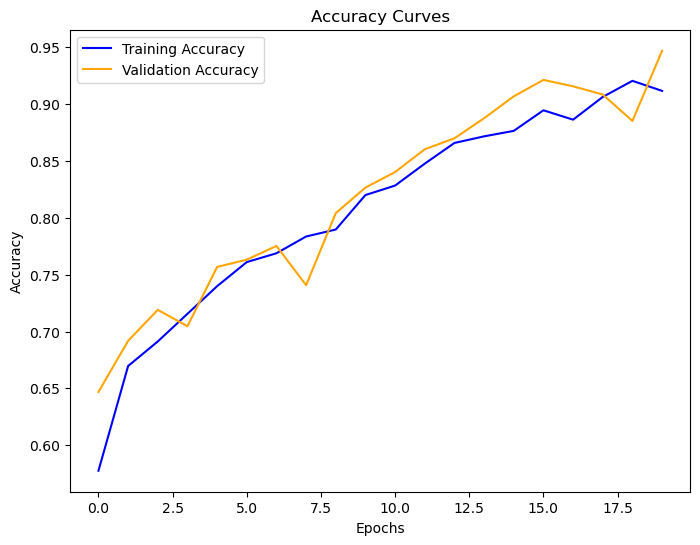

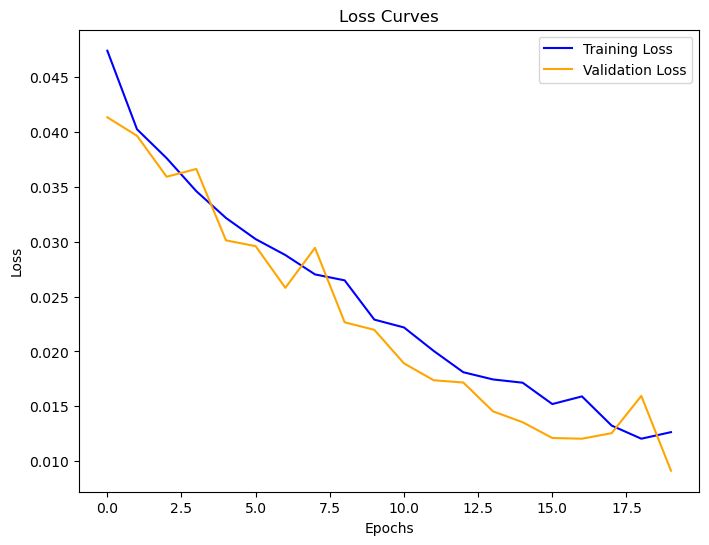

In [41]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss curves.
    """
    # Accuracy curves
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function to plot training history
plot_training_history(history)


39/39 [==============================] - 10s 263ms/step


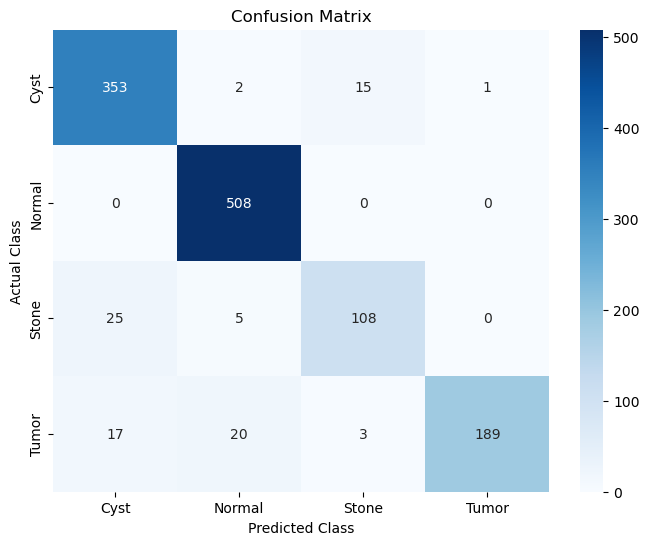

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.89      0.95      0.92       371
      Normal       0.95      1.00      0.97       508
       Stone       0.86      0.78      0.82       138
       Tumor       0.99      0.83      0.90       229

    accuracy                           0.93      1246
   macro avg       0.92      0.89      0.90      1246
weighted avg       0.93      0.93      0.93      1246



In [42]:
# Evaluate the model on the test data
def evaluate_model(model, test_generator):
    """
    Evaluate the model using confusion matrix and classification report.
    """
    # Predict on test data
    test_steps = test_generator.samples // test_generator.batch_size + 1
    predictions = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    # Classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)

# Call the function to evaluate the model
evaluate_model(model, test_generator)
